# EDA DE PROYECTO FINAL

**Desarrollado por:**  
Johan Díaz  
Héctor Sanjuan  
Miguel Lugo  
Luis David Peñaranda

---

## Índice

- **1. Regresión Logística para revisión de scores**
    - 1.1. Carga de datos  
    - 1.2. Exploración inicial de la estructura y datos faltantes  
    - 1.3. Verificación de imputación por KNN  
    - 1.4. Análisis de resultados  
- **2. Análisis Exploratorio de Datos (EDA)**
    - 2.1. Análisis de los datos  
    - 2.2. La columna objetivo (`target`)  
    - 2.3. Visualización de target  
    - 2.4. Variables numéricas vs. target  
    - 2.5. Comparación de distribución  
    - 2.6. Correlación  
    - 2.7. Conclusión del Análisis Exploratorio de Datos

# 1. REGRESIÓN LOGÍSTICA PARA REVISIÓN DE SCORES

Resumen del Conjunto de Datos

Filas: 100,000 individuos

Columnas: 40 características + 1 objetivo

Variable Objetivo: target → Clasificación binaria:

saludable

con enfermedad

Desbalanceado: ~70% healthy, ~30% diseased

Tipos de Datos: Numéricos, categóricos, ordinales

Definición de la Variable Objetivo
La columna objetivo indica si una persona ha sido diagnosticada con una determinada enfermedad o no. La clasificación se basa en indicadores médicos y de estilo de vida derivados del perfil del individuo.

## REGRESIÓN LOGÍSTICA APLICADA LUEGO DE IMPUTACIÓN POR KNN

### Aplicamos balanceo con SMOTE (Synthetic Minority Over-sampling Technique) e imputación con KNN

In [1]:
!pip install imbalanced-learn

Acceso denegado.


In [2]:
from imblearn.over_sampling import SMOTE

### 1.1. Carga de los Datos

Para empezar, necesitamos cargar los datos. Para que este notebook lo pueda usar cualquiera sin descargar archivos manualmente, hemos creado una función que se conecta a un link de GitHub, baja un archivo `.zip`, lo descomprime y carga el archivo `.csv` que tiene adentro. Así el proceso es automático y fácil.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import zipfile
from io import BytesIO

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, auc

# Estilo visual
sns.set(style="darkgrid")

def load_health_data():
    PERMANENT_LINK = "https://github.com/johand-lopez/eda_ml/blob/8530ff0aaf5e5d556e3994c15e45f576b629bcde/data.zip"
    RAW_LINK = PERMANENT_LINK.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")

    try:
        print(f"Descargando desde: {RAW_LINK}")
        response = requests.get(RAW_LINK, timeout=10)
        response.raise_for_status()  # Verifica errores HTTP
        
        with zipfile.ZipFile(BytesIO(response.content)) as z:
            csv_name = [f for f in z.namelist() if f.endswith('.csv')][0]
            with z.open(csv_name) as f:
                print(f" Archivo '{csv_name}' cargado correctamente")
                return pd.read_csv(f)
    
    except Exception as e:
        print(f"Error durante la carga: {str(e)}")
        print("\nSolución de problemas:")
        print(f"1. Verifica que el enlace sea accesible: {RAW_LINK}")
        print("2. Asegúrate que el ZIP contiene un CSV")
        print("3. Revisa tu conexión a internet")
        return None

df = load_health_data()

if df is None:
    raise SystemExit("No se pudo cargar el dataset. Detén la ejecución y revisa el enlace o tu conexión.")

Descargando desde: https://raw.githubusercontent.com/johand-lopez/eda_ml/8530ff0aaf5e5d556e3994c15e45f576b629bcde/data.zip
 Archivo 'health_lifestyle_classification.csv' cargado correctamente


### 1.2. Exploración inicial de la estructura y datos faltantes

Antes de aplicar la técnicas de imputación KNN, es fundamental comprender la estructura del conjunto de datos. En esta sección inspeccionamos las primeras filas y el tipo de variables. Esta información nos permite identificar posibles problemas de calidad de los datos y tomar decisiones informadas sobre el preprocesamiento.

### Estudio inicial

In [4]:
print("\nVista previa del DataFrame:")
df.head(5)

print("\nInformación general del DataFrame:")
df.info()


Vista previa del DataFrame:

Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 48 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   survey_code               100000 non-null  int64  
 1   age                       100000 non-null  int64  
 2   gender                    100000 non-null  object 
 3   height                    100000 non-null  float64
 4   weight                    100000 non-null  float64
 5   bmi                       100000 non-null  float64
 6   bmi_estimated             100000 non-null  float64
 7   bmi_scaled                100000 non-null  float64
 8   bmi_corrected             100000 non-null  float64
 9   waist_size                100000 non-null  float64
 10  blood_pressure            92331 non-null   float64
 11  heart_rate                85997 non-null   float64
 12  cholesterol               100000 non

### Datos Faltantes

In [5]:
# Cálculo de valores nulos y su porcentaje
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Faltantes': missing,
    'Porcentaje (%)': missing_percent
})

# Mostrar solo las columnas con datos faltantes
missing_df = missing_df[missing_df['Faltantes'] > 0].sort_values(by='Faltantes', ascending=False)

print("\n⚠️ Resumen de valores faltantes por variable:")
print(missing_df)


⚠️ Resumen de valores faltantes por variable:
                     Faltantes  Porcentaje (%)
alcohol_consumption      42387          42.387
caffeine_intake          33261          33.261
exercise_type            24969          24.969
insulin                  15836          15.836
heart_rate               14003          14.003
gene_marker_flag         10474          10.474
income                    8470           8.470
daily_steps               8329           8.329
blood_pressure            7669           7.669


### Visualización de datos faltantes

Para identificar de forma más clara las variables con valores faltantes, realizamos un gráfico de barras con el porcentaje de datos faltantes por variable.

c:\Users\johan\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\johan\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\johan\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\johan\AppData\Local\Temp\ipykernel_31400\2164169462.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\johan\miniconda3\envs\m

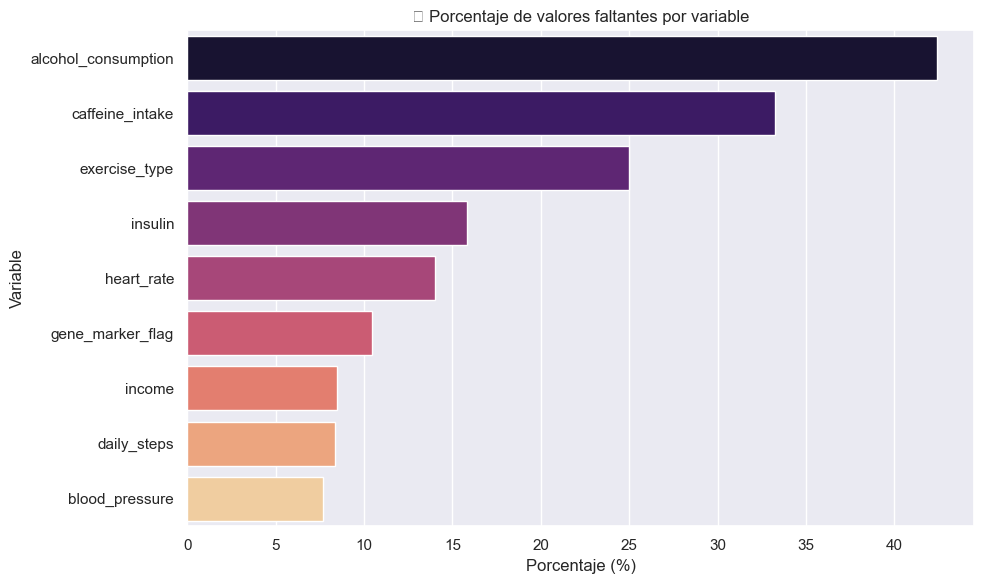

In [6]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Variable': missing.index, 'Porcentaje': missing_percent})
missing_df = missing_df[missing_df['Porcentaje'] > 0].sort_values(by='Porcentaje', ascending=False)

# Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=missing_df, x='Porcentaje', y='Variable', palette='magma')
plt.title("📊 Porcentaje de valores faltantes por variable")
plt.xlabel("Porcentaje (%)")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

In [7]:
num_cols = [
    'age', 'bmi', 'blood_pressure', 'cholesterol', 'heart_rate',
    'glucose', 'insulin', 'calorie_intake', 'sugar_intake',
    'screen_time', 'stress_level', 'mental_health_score'
]

cat_cols = [
    'gender', 'marital_status', 'diet_type', 'occupation',
    'sleep_quality', 'mental_health_support', 'exercise_type',
    'device_usage', 'healthcare_access', 'insurance',
    'family_history', 'sunlight_exposure'
]

cat_cols = [col for col in cat_cols if col in df.columns]

# Imputar valores nulos
num_imputer = SimpleImputer(strategy='mean')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])


cat_cols = [col for col in cat_cols if col in df.columns]

# Añade las columnas tipo objeto que faltan
extra_cat_cols = ['alcohol_consumption', 'smoking_level', 'education_level', 'job_type', 'caffeine_intake', 'pet_owner']
cat_cols += [col for col in extra_cat_cols if col in df.columns and col not in cat_cols]

# One-hot encoding para categóricas
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Variable objetivo
y = df_encoded["target"]
X = df_encoded.drop("target", axis=1)

from sklearn.impute import KNNImputer

# Imputación por KNN
knn_imputer = KNNImputer(n_neighbors=5)
X = pd.DataFrame(knn_imputer.fit_transform(X), columns=X.columns)

# Escalar variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Balanceo de clases en el set de entrenamiento
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Modelo con regularización más fuerte
model = LogisticRegression(max_iter=1000, class_weight='balanced', C=0.5)
model.fit(X_train_bal, y_train_bal)

# Predicción y evaluación
y_pred = model.predict(X_test)

# Verifica columnas con nulos después de la imputación
null_cols = X.columns[X.isnull().any()].tolist()
print("\nColumnas con nulos en X:", null_cols)
print("Total de nulos por columna:\n", X.isnull().sum())

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Modelo con regularización más fuerte
model = LogisticRegression(max_iter=1000, class_weight='balanced', C=0.5)
model.fit(X_train, y_train)

# Predicción y evaluación
y_pred = model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))



Columnas con nulos en X: []
Total de nulos por columna:
 survey_code                 0
age                         0
height                      0
weight                      0
bmi                         0
                           ..
job_type_Service            0
job_type_Tech               0
job_type_Unemployed         0
caffeine_intake_Moderate    0
pet_owner_Yes               0
Length: 66, dtype: int64

Accuracy: 0.51045

Reporte de Clasificación:
              precision    recall  f1-score   support

    diseased       0.30      0.48      0.37      5981
     healthy       0.70      0.52      0.60     14019

    accuracy                           0.51     20000
   macro avg       0.50      0.50      0.48     20000
weighted avg       0.58      0.51      0.53     20000


Accuracy: 0.49935

Reporte de Clasificación:
              precision    recall  f1-score   support

    diseased       0.30      0.50      0.38      5981
     healthy       0.70      0.50      0.58     14019

    

### 1.3. Verificación de imputación por KNN

Después de aplicar la imputación por KNN, verificamos que no queden valores nulos en las variables predictoras.

In [8]:
null_count = X.isnull().sum().sum()

if null_count == 0:
    print("✅ Todos los valores nulos han sido imputados correctamente con KNN.")
else:
    print(f"⚠️ Aún quedan {null_count} valores nulos después de la imputación con KNN.")
    print("Resumen por columna con nulos restantes:")
    print(X.isnull().sum()[X.isnull().sum() > 0])

✅ Todos los valores nulos han sido imputados correctamente con KNN.


### 1.4. Análisis

Escogimos KNN como método de imputación porque permite estimar valores faltantes basándose en la similitud entre observaciones, lo cual ofrece una imputación más robusta que simplemente usar la media o la moda. Esta elección está alineada con nuestro objetivo de preparar los datos para modelos más complejos en fases posteriores del proyecto, asegurando así una mejor calidad en las predicciones.

**1. Accuracy bajo (~0.50)**
El modelo apenas supera el azar. Esto indica que no está logrando distinguir bien entre "healthy" y "diseased", probablemente por el desbalance de clases y/o falta de información relevante.

**2. Precision y Recall desbalanceados**
Para la clase diseased:
Precision baja (0.30): Muchas predicciones positivas son incorrectas.
Recall moderado (0.48): El modelo detecta menos de la mitad de los casos reales.
Para la clase healthy:
Precision aceptable (0.70): La mayoría de los positivos predichos son correctos.
Recall bajo (0.52): El modelo no detecta todos los casos reales.

**3. F1-score bajo en ambas clases**
El F1-score, que balancea precision y recall, es bajo para ambas clases, lo que indica que el modelo no logra un buen equilibrio entre ambos.

**4. Macro y Weighted Average cercanos a 0.5**
Esto confirma que el modelo no está aprendiendo patrones útiles y que el desbalance de clases afecta negativamente el desempeño.

## 2. Análisis Exploratorio de Datos (EDA)

Después de completar el proceso de limpieza, imputación y preparación de los datos, estamos en condiciones de realizar el Análisis Exploratorio de Datos (EDA). Esta etapa nos permitirá comprender mejor la distribución de las variables, identificar patrones, relaciones entre características, y posibles diferencias entre los grupos de estudio. El objetivo es obtener información relevante que nos oriente en la construcción y evaluación de los modelos predictivos.

In [9]:
import pandas as pd
import numpy as np
import requests
import zipfile
from io import BytesIO

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-deep')

### 2.1. Analisis de los datos

Ahora que los datos están cargados, vamos a hacer una revisión rápida para empezar a conocer los datos.

In [10]:
print("Resumen técnico del DataFrame:")
df.info()

Resumen técnico del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 48 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   survey_code               100000 non-null  int64  
 1   age                       100000 non-null  float64
 2   gender                    100000 non-null  object 
 3   height                    100000 non-null  float64
 4   weight                    100000 non-null  float64
 5   bmi                       100000 non-null  float64
 6   bmi_estimated             100000 non-null  float64
 7   bmi_scaled                100000 non-null  float64
 8   bmi_corrected             100000 non-null  float64
 9   waist_size                100000 non-null  float64
 10  blood_pressure            100000 non-null  float64
 11  heart_rate                100000 non-null  float64
 12  cholesterol               100000 non-null  float64
 13  glucose       

En la primera etapa de nuestro Análisis Exploratorio de Datos (EDA), examinamos la estructura general del conjunto de datos.

-   **Tamaño del conjunto de datos:** Verificamos que el conjunto de datos contiene 100,000 registros y 48 variables. Esto confirma la información inicial que teníamos y nos da una idea del volumen de datos con el que estamos trabajando.
-   **Tipos de datos:** Encontramos que las variables se dividen en tipos numéricos (`float64`, `int64`) y categóricos (`object`). 
-   **Valores faltantes:** Un hallazgo crucial es la presencia de valores nulos o faltantes en varias columnas. Específicamente, notamos que:
    -   `blood_pressure` tiene 7,669 valores faltantes.
    -   `heart_rate` tiene 14,003 valores faltantes.
    -   `insulin` tiene 15,836 valores faltantes.

In [11]:
print("\nResumen de las variables numéricas:")
display(df.describe().T)


Resumen de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
survey_code,100000.0,50000.500000,28867.657797,1.000000,25000.750000,50000.500000,75000.250000,100000.000000
age,100000.0,48.525990,17.886768,18.000000,33.000000,48.000000,64.000000,79.000000
height,100000.0,170.023707,9.982798,140.000000,163.306615,170.016778,176.728920,210.000000
weight,100000.0,70.064862,14.693667,40.000000,59.856938,69.924141,80.027418,139.250894
bmi,100000.0,24.493876,5.951069,9.988495,20.271405,24.156734,28.258696,59.234792
bmi_estimated,100000.0,24.493876,5.951069,9.988495,20.271405,24.156734,28.258696,59.234792
bmi_scaled,100000.0,73.481627,17.853206,29.965484,60.814215,72.470201,84.776088,177.704377
bmi_corrected,100000.0,24.494140,5.954184,9.893845,20.271059,24.151699,28.247648,59.142646
waist_size,100000.0,84.933043,12.040314,34.093185,76.795185,84.957139,93.018713,133.153631
blood_pressure,100000.0,119.980149,14.428244,59.128168,110.815119,119.980149,129.185145,184.439195


A partir de la tabla de estadísticas descriptivas (describe), realizamos las siguientes observaciones:

1.  **Valores Faltantes (Nulos):**
    -   Confirmamos la presencia de valores faltantes en `blood_pressure`, `heart_rate` e `insulin`.
    -   Además, encontramos nuevos valores faltantes en otras variables, como `daily_steps` (le faltan 8,329 registros) y `gene_marker_flag` (le faltan 10,474 registros).

2.  **Identificación de Datos Inconsistentes:**
    -   Descubrimos valores imposibles en algunas variables:
        -   `sugar_intake` y `daily_supplement_dosage` tienen valores mínimos negativos (-27.88 y -9.99, respectivamente), lo cual es un claro error de datos. Estos valores deberán ser eliminados o corregidos.
    -   Observamos la distribución de otras variables:
        -   `income` muestra un rango muy amplio, con un mínimo de 500 y un máximo de 1.2 millones. Esto indica una alta variabilidad en los ingresos y podría haber valores atípicos que necesiten ser examinados.
        -   `screen_time` tiene un mínimo de 0.5 horas y un máximo de 16 horas. La media (6.02) y la mediana (5.0) están cerca, pero el máximo sugiere que algunos individuos pasan una cantidad de tiempo en pantalla significativamente alta.

3.  **Distribución de las Variables:**
    -   Las variables `stress_level` y `mental_health_score` (ambas en una escala de 0 a 10) tienen una media de aproximadamente 5, lo que indica que los datos están bastante centrados en la mitad de la escala.
    -   Variables como `age`, `height`, `weight` y `bmi` tienen rangos y distribuciones que parecen ser razonables, lo que nos da confianza en la calidad de estos datos.

En resumen, esta exploración inicial nos ha permitido confirmar los valores faltantes y, de manera crucial, identificar problemas de calidad en los datos como los valores negativos en la ingesta de azúcar y la dosis de suplementos. Estos hallazgos serán prioritarios en la etapa de limpieza y preprocesamiento de los datos.

### 2.2. La Columna Objetivo (`target`)
Ahora nos vamos a enfocar en cada columna por separado. Empezamos por la columna más importante: `target`, que nos dice si una persona está sana (`healthy`) o tiene una enfermedad (`diseased`).

c:\Users\johan\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\johan\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\johan\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


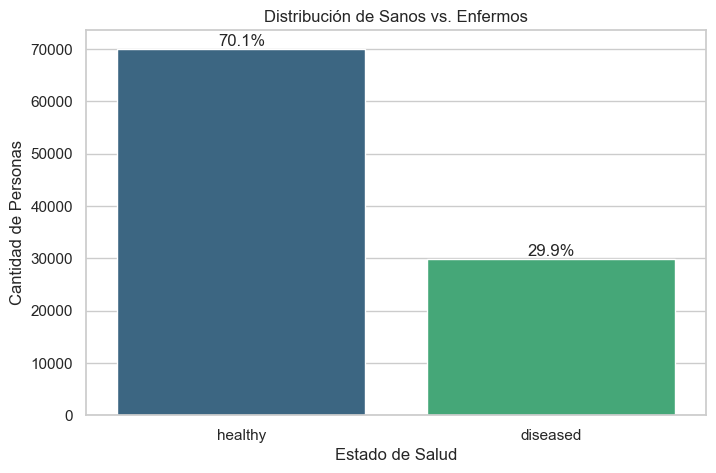

target
healthy     70097
diseased    29903
Name: count, dtype: int64


In [12]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='target', data=df, palette='viridis')
plt.title('Distribución de Sanos vs. Enfermos')
plt.xlabel('Estado de Salud')
plt.ylabel('Cantidad de Personas')

total = len(df['target'])
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()

print(df['target'].value_counts())

### 2.3.
En este paso, visualizamos la distribución de la variable objetivo, `target`, que categoriza a los individuos como "healthy" (sanos) o "diseased" (enfermos).

-   **Desequilibrio del conjunto de datos:** Como ya anticipamos en la descripción inicial, el gráfico de barras confirma que nuestro conjunto de datos está desequilibrado.
-   **Proporción de clases:** Encontramos que el 70.1% de los individuos (`70,097`) pertenecen a la clase "healthy" y el 29.9% (`29,903`) pertenecen a la clase "diseased".

Para las columnas que tienen números (como edad, colesterol, etc.), vamos a usar dos tipos de gráficos:
- **Histogramas:** para ver la "forma" de los datos y dónde se concentran más.
- **Diagramas de caja:** para ver qué tan dispersos están los datos y si hay valores "atípicos" o muy extremos.

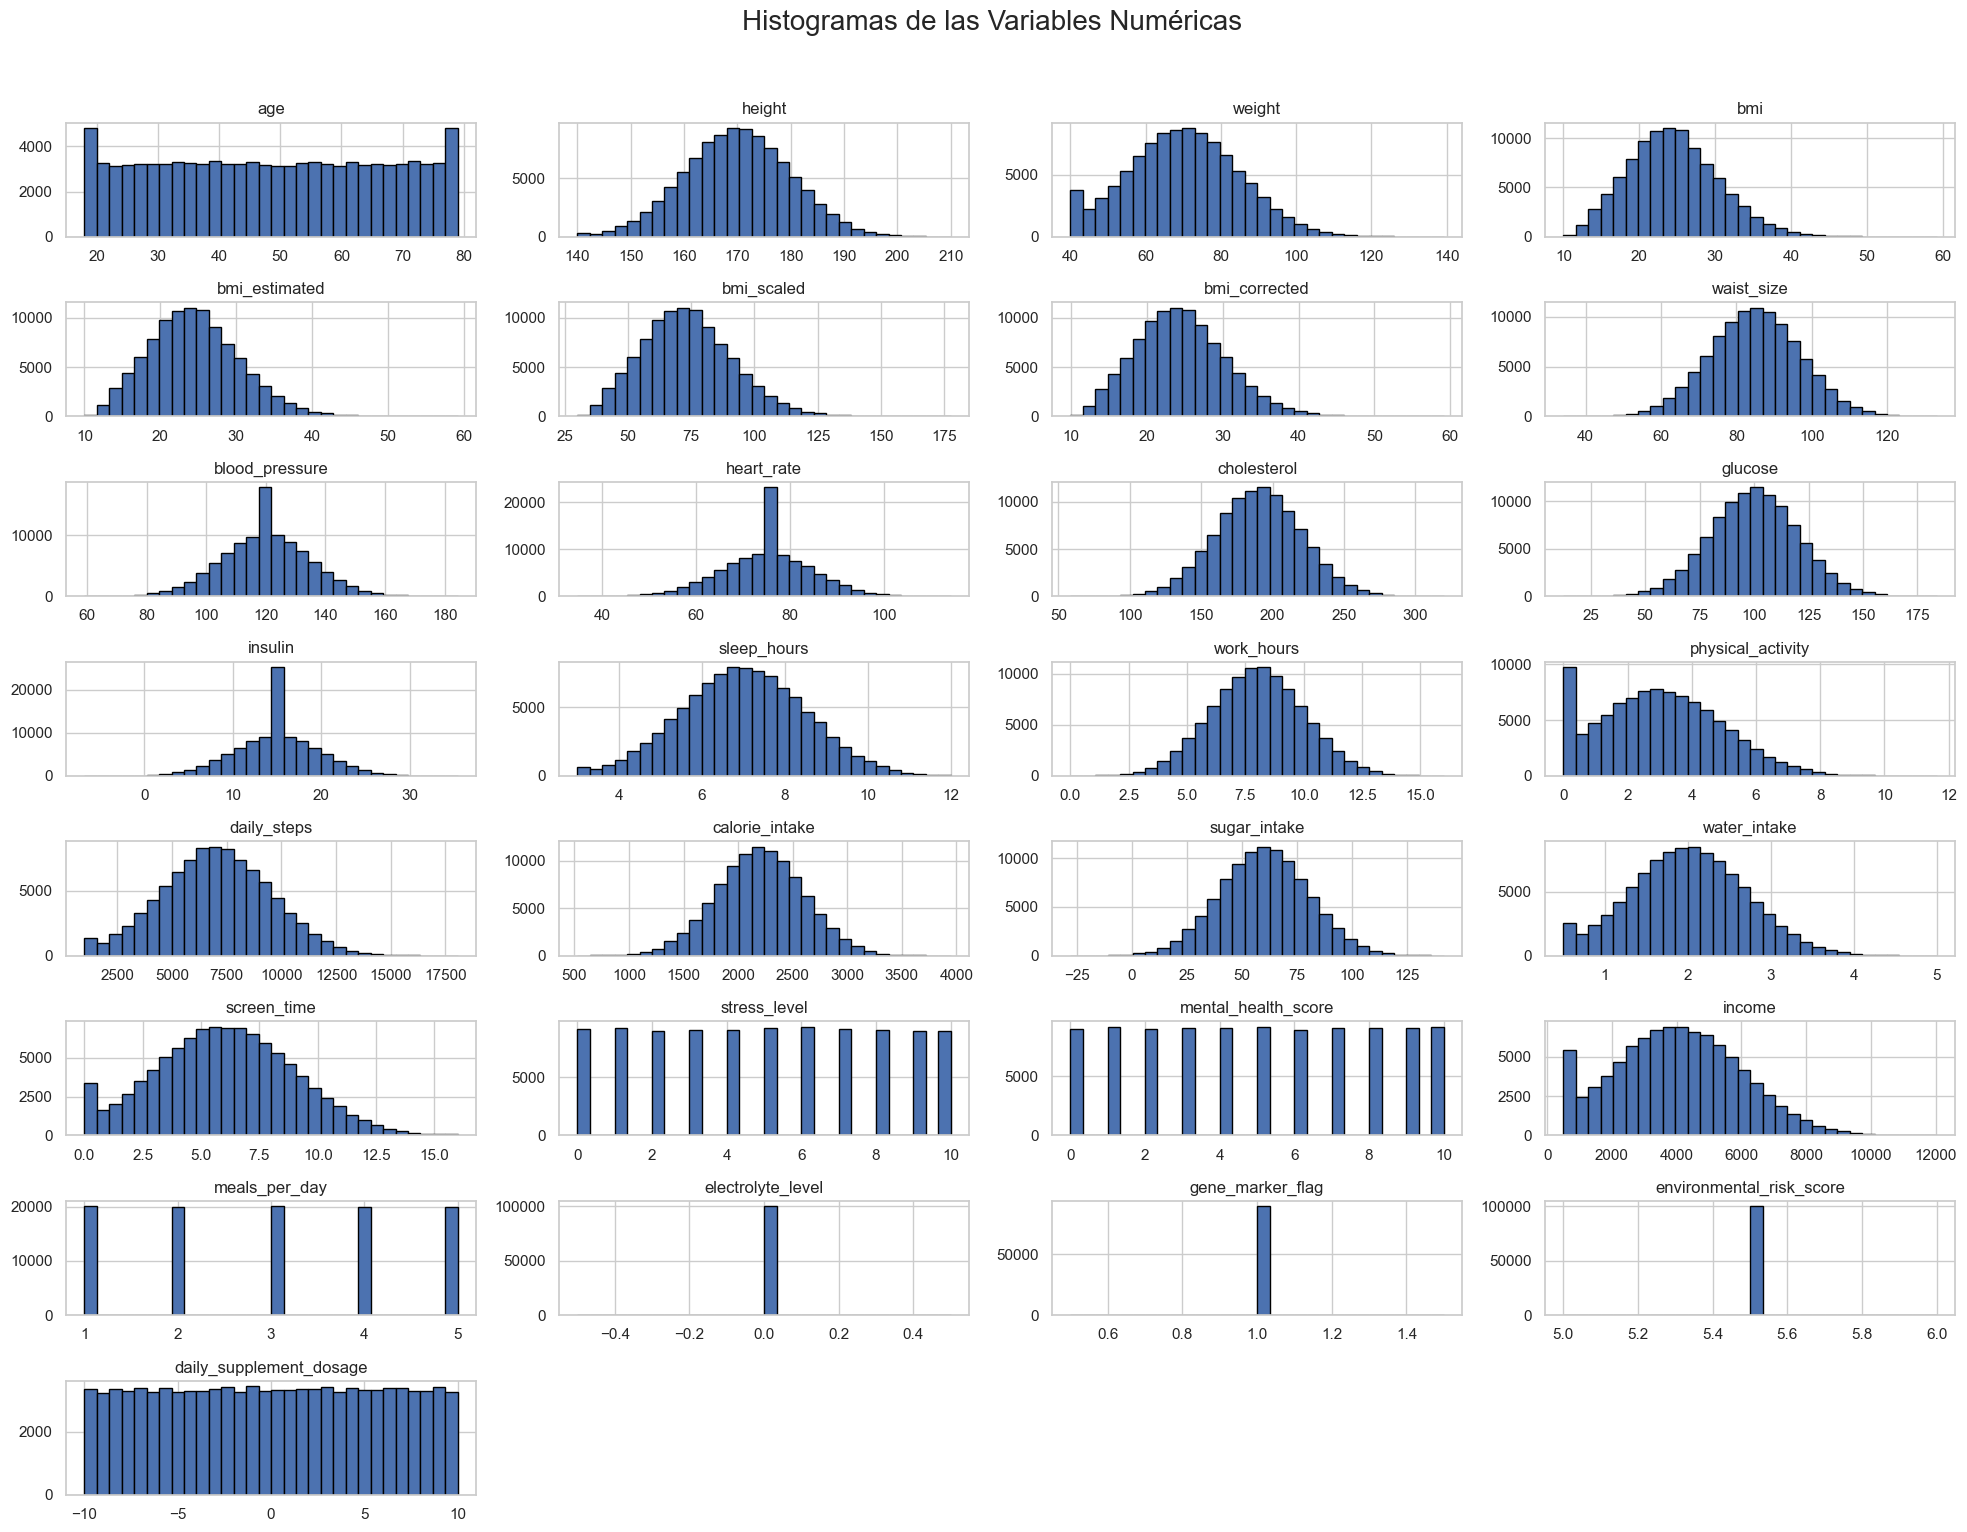

In [13]:
numeric_features = df.select_dtypes(include=np.number).columns.tolist()

numeric_features.remove('survey_code') 

df[numeric_features].hist(bins=30, figsize=(20, 15), layout=(-1, 4), edgecolor='black')
plt.suptitle('Histogramas de las Variables Numéricas', size=20, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

## Distribución de Variables Numéricas

El análisis de histogramas proporciona una vista general del comportamiento estadístico de las variables numéricas, permitiéndonos detectar patrones, sesgos y posibles anomalías en los datos. A partir del gráfico anterior, extraemos los siguientes hallazgos:

### Distribuciones Aproximadamente Normales

Varias variables muestran distribuciones simétricas en forma de campana, lo que sugiere una buena calidad de datos y estabilidad estadística:

- **`height`**, **`weight`**, **`blood_pressure`**, **`cholesterol`**, **`glucose`**, **`sleep_hours`**, **`calorie_intake`**, **`water_intake`**: Estas variables tienen una forma cercana a la distribución normal, con concentraciones de datos alrededor de la media. Son candidatas ideales para técnicas estadísticas clásicas que asumen normalidad.

### Distribuciones Asimétricas (Sesgadas a la Derecha)

Estas variables presentan una concentración de observaciones en valores bajos y una cola larga hacia la derecha. En tales casos, la mediana puede ser una mejor medida de tendencia central:

- **`insulin`**, **`physical_activity`**, **`daily_steps`**, **`screen_time`**, **`sugar_intake`**: Este comportamiento es común en métricas que tienen un límite inferior natural (cero) y pocos casos con valores muy altos. Su transformación (como logaritmos) podría ayudar en ciertos modelos.

### Distribuciones Uniformes o Artificiales

Algunas variables muestran comportamientos particulares que pueden tener causas técnicas o de recolección de datos:

- **`age`**: Muestra una distribución relativamente uniforme, lo que indica buena representación de todas las edades. Esto es útil para evitar sesgos etarios en el modelo.
- **`stress_level`**, **`mental_health_score`**, **`meals_per_day`**: Tienen distribuciones discretas o uniformemente distribuidas, probablemente debido a su escala categórica o limitada por diseño.
- **`work_hours`**: Está fuertemente concentrada en 8 horas, lo que refleja un patrón laboral estándar.

### Valores Atípicos o Anómalos

- **`sugar_intake`**: Se observan valores negativos en el histograma, lo cual es inverosímil en el contexto fisiológico y sugiere errores en la entrada de datos. Esto requerirá limpieza o imputación.

- **`electrolyte_level`**, **`gene_marker_flag`**, **`environmental_risk_score`**: Estas variables presentan patrones de distribución sospechosos (picos únicos o valores constantes), lo cual podría indicar codificación incorrecta, falta de variabilidad o necesidad de revisar su utilidad.

c:\Users\johan\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\johan\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\johan\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\johan\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

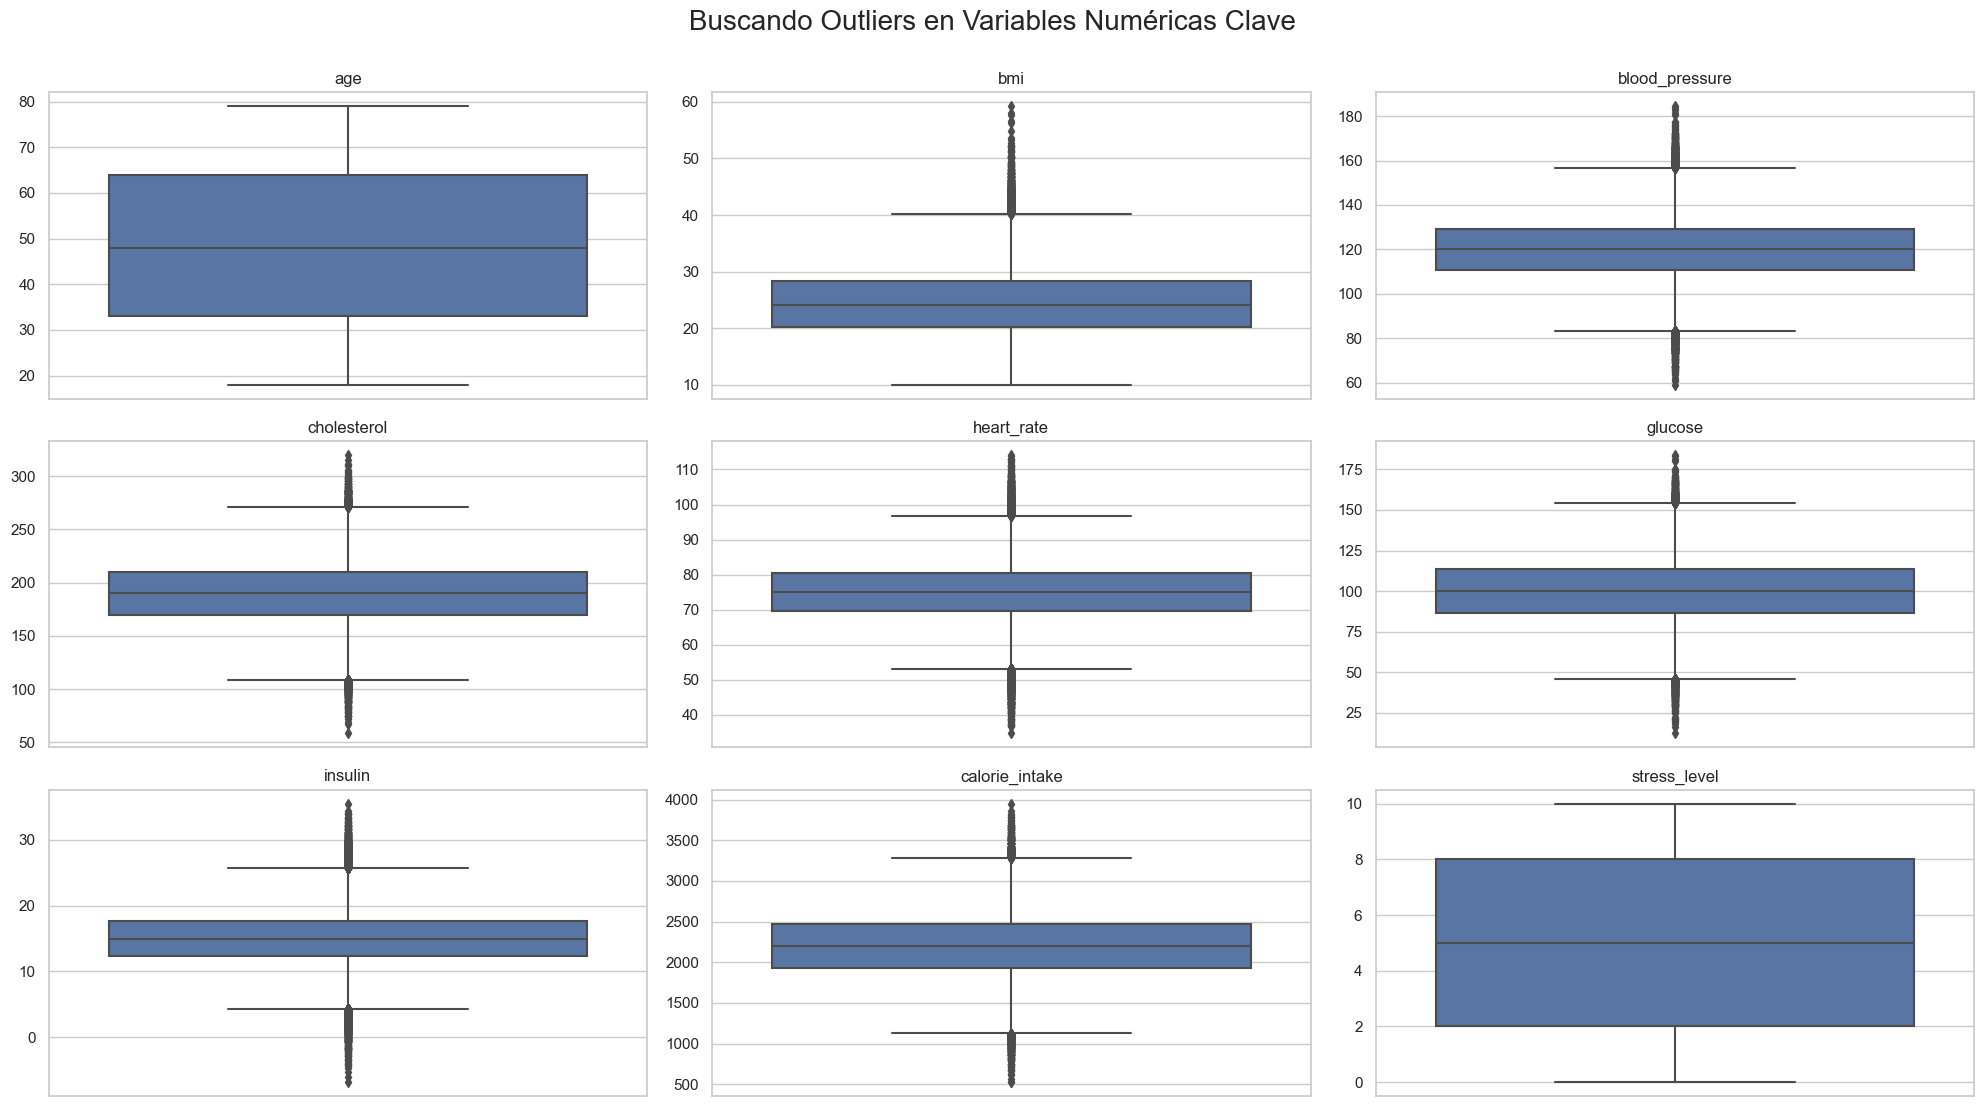

In [14]:
plt.figure(figsize=(20, 12))
plt.suptitle('Buscando Outliers en Variables Numéricas Clave', size=20, y=0.95)

features_to_plot = ['age', 'bmi', 'blood_pressure', 'cholesterol', 'heart_rate', 'glucose', 'insulin', 'calorie_intake', 'stress_level']

for i, col in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col)
    plt.ylabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Presencia Generalizada de Outliers:**  
  Se observa una alta presencia de outliers en múltiples variables biométricas, incluyendo `blood_pressure`, `cholesterol`, `heart_rate`, `glucose` y `calorie_intake`. Estos outliers aparecen en ambos extremos, aunque predominan los valores altos. Esta dispersión podría estar asociada a casos clínicos extremos que requieren atención especial en el modelado.

- **Outliers en Variables con Distribución Asimétrica:**  
  Las variables `bmi` e `insulin` presentan una concentración significativa de outliers en el extremo superior. Esto concuerda con la distribución asimétrica positiva observada en los histogramas. Estos valores extremos podrían tener una alta correlación con la condición "diseased", por lo que podrían ser relevantes para el rendimiento de los modelos predictivos.

- **Variables con Distribución Controlada:**  
  Variables como `age` y `stress_level` muestran boxplots más compactos, sin presencia notable de outliers. Esto sugiere que sus datos están distribuidos de manera más uniforme y dentro de rangos biológicamente esperados, por lo que no se requiere tratamiento especial para valores extremos.

- **Consideraciones para el Preprocesamiento:**  
  Dado que algunos modelos de machine learning (como SVM o regresiones lineales) son sensibles a outliers, se recomienda considerar estrategias como Winsorización o detección con IQR/z-score para mitigar su impacto, especialmente en variables altamente sesgadas como `insulin`.


### 2.4. Variables Numéricas vs. Target
Ahora vamos a empezar a cruzarlas de dos en dos. Nos interesa saber **cómo se relaciona cada característica con la variable `target`**.
Ahora vamos a ver si los valores numéricos (como la presión arterial o el IMC) son distintos para la gente sana y la gente enferma.

c:\Users\johan\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\johan\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\johan\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\johan\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

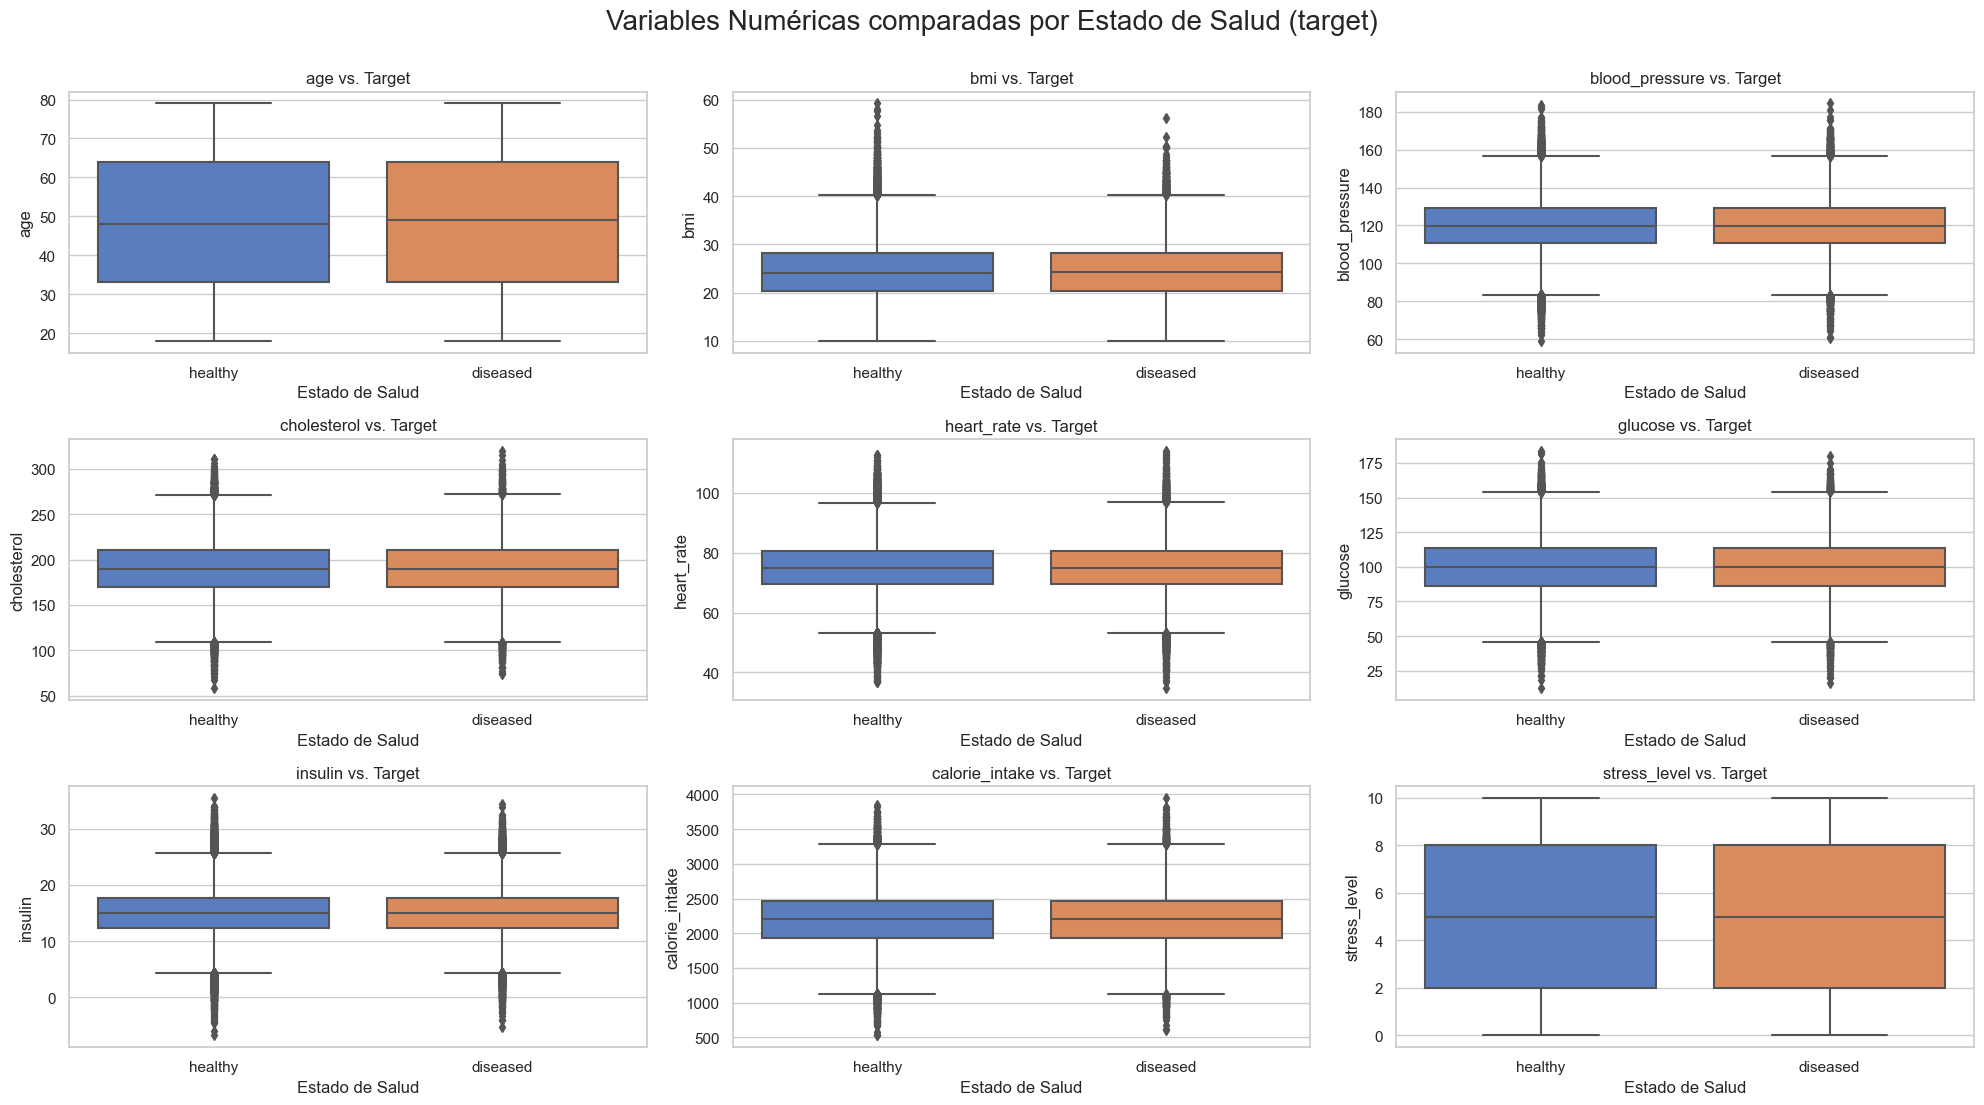

In [15]:

plt.figure(figsize=(20, 12))
plt.suptitle('Variables Numéricas comparadas por Estado de Salud (target)', size=20, y=0.95)

for i, col in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='target', y=col, data=df, palette='muted')
    plt.title(f'{col} vs. Target')
    plt.xlabel('Estado de Salud')
    plt.ylabel(col)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Comparación de Variables Numéricas por Estado de Salud (`target`)

El análisis de estos boxplots segmentados por la variable objetivo (`healthy` vs. `diseased`) nos permite identificar qué variables podrían tener un mayor poder explicativo o predictivo frente al estado de salud. A continuación se destacan los hallazgos más relevantes:

### Variables con Alta Discriminación entre Grupos

Las siguientes variables muestran diferencias claras en su distribución entre personas sanas y enfermas, lo cual indica su potencial como predictores del estado de salud:

- **`age`**: Las personas con enfermedad tienden a ser mayores, con una mediana desplazada hacia la derecha respecto al grupo sano.
- **`bmi`**: El índice de masa corporal es consistentemente más alto en el grupo enfermo, lo que sugiere una posible asociación con condiciones metabólicas.
- **`blood_pressure`**: Se observa un aumento en la presión arterial en individuos enfermos, con una ligera expansión en los cuartiles.
- **`cholesterol`**: Aunque la diferencia no es tan pronunciada, el grupo enfermo presenta una mediana y rango ligeramente más altos.
- **`glucose`**: Claramente más elevados en el grupo `diseased`, los niveles de glucosa podrían ser uno de los marcadores más fuertes.
- **`insulin`**: Las personas enfermas tienden a tener niveles más altos de insulina, reflejando posibles problemas de regulación metabólica.
- **`stress_level`**: Aunque menos marcado, el grupo enfermo presenta una leve tendencia a niveles más altos de estrés.

Estas variables no solo presentan desplazamientos en la mediana, sino también un aumento en la dispersión, lo cual puede enriquecer la capacidad del modelo para capturar patrones complejos.

### Variables con Bajo Poder Predictivo

- **`heart_rate`**: Las distribuciones son muy similares entre ambos grupos, con medianas y rangos prácticamente idénticos.
- **`calorie_intake`**: No se observa una diferencia significativa entre grupos, por lo que su valor predictivo podría ser limitado.



Ahora vamos a ver si alguna categoría (como ser fumador o el tipo de dieta) es más común en el grupo de enfermos que en el de sanos.

c:\Users\johan\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\johan\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\johan\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\johan\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

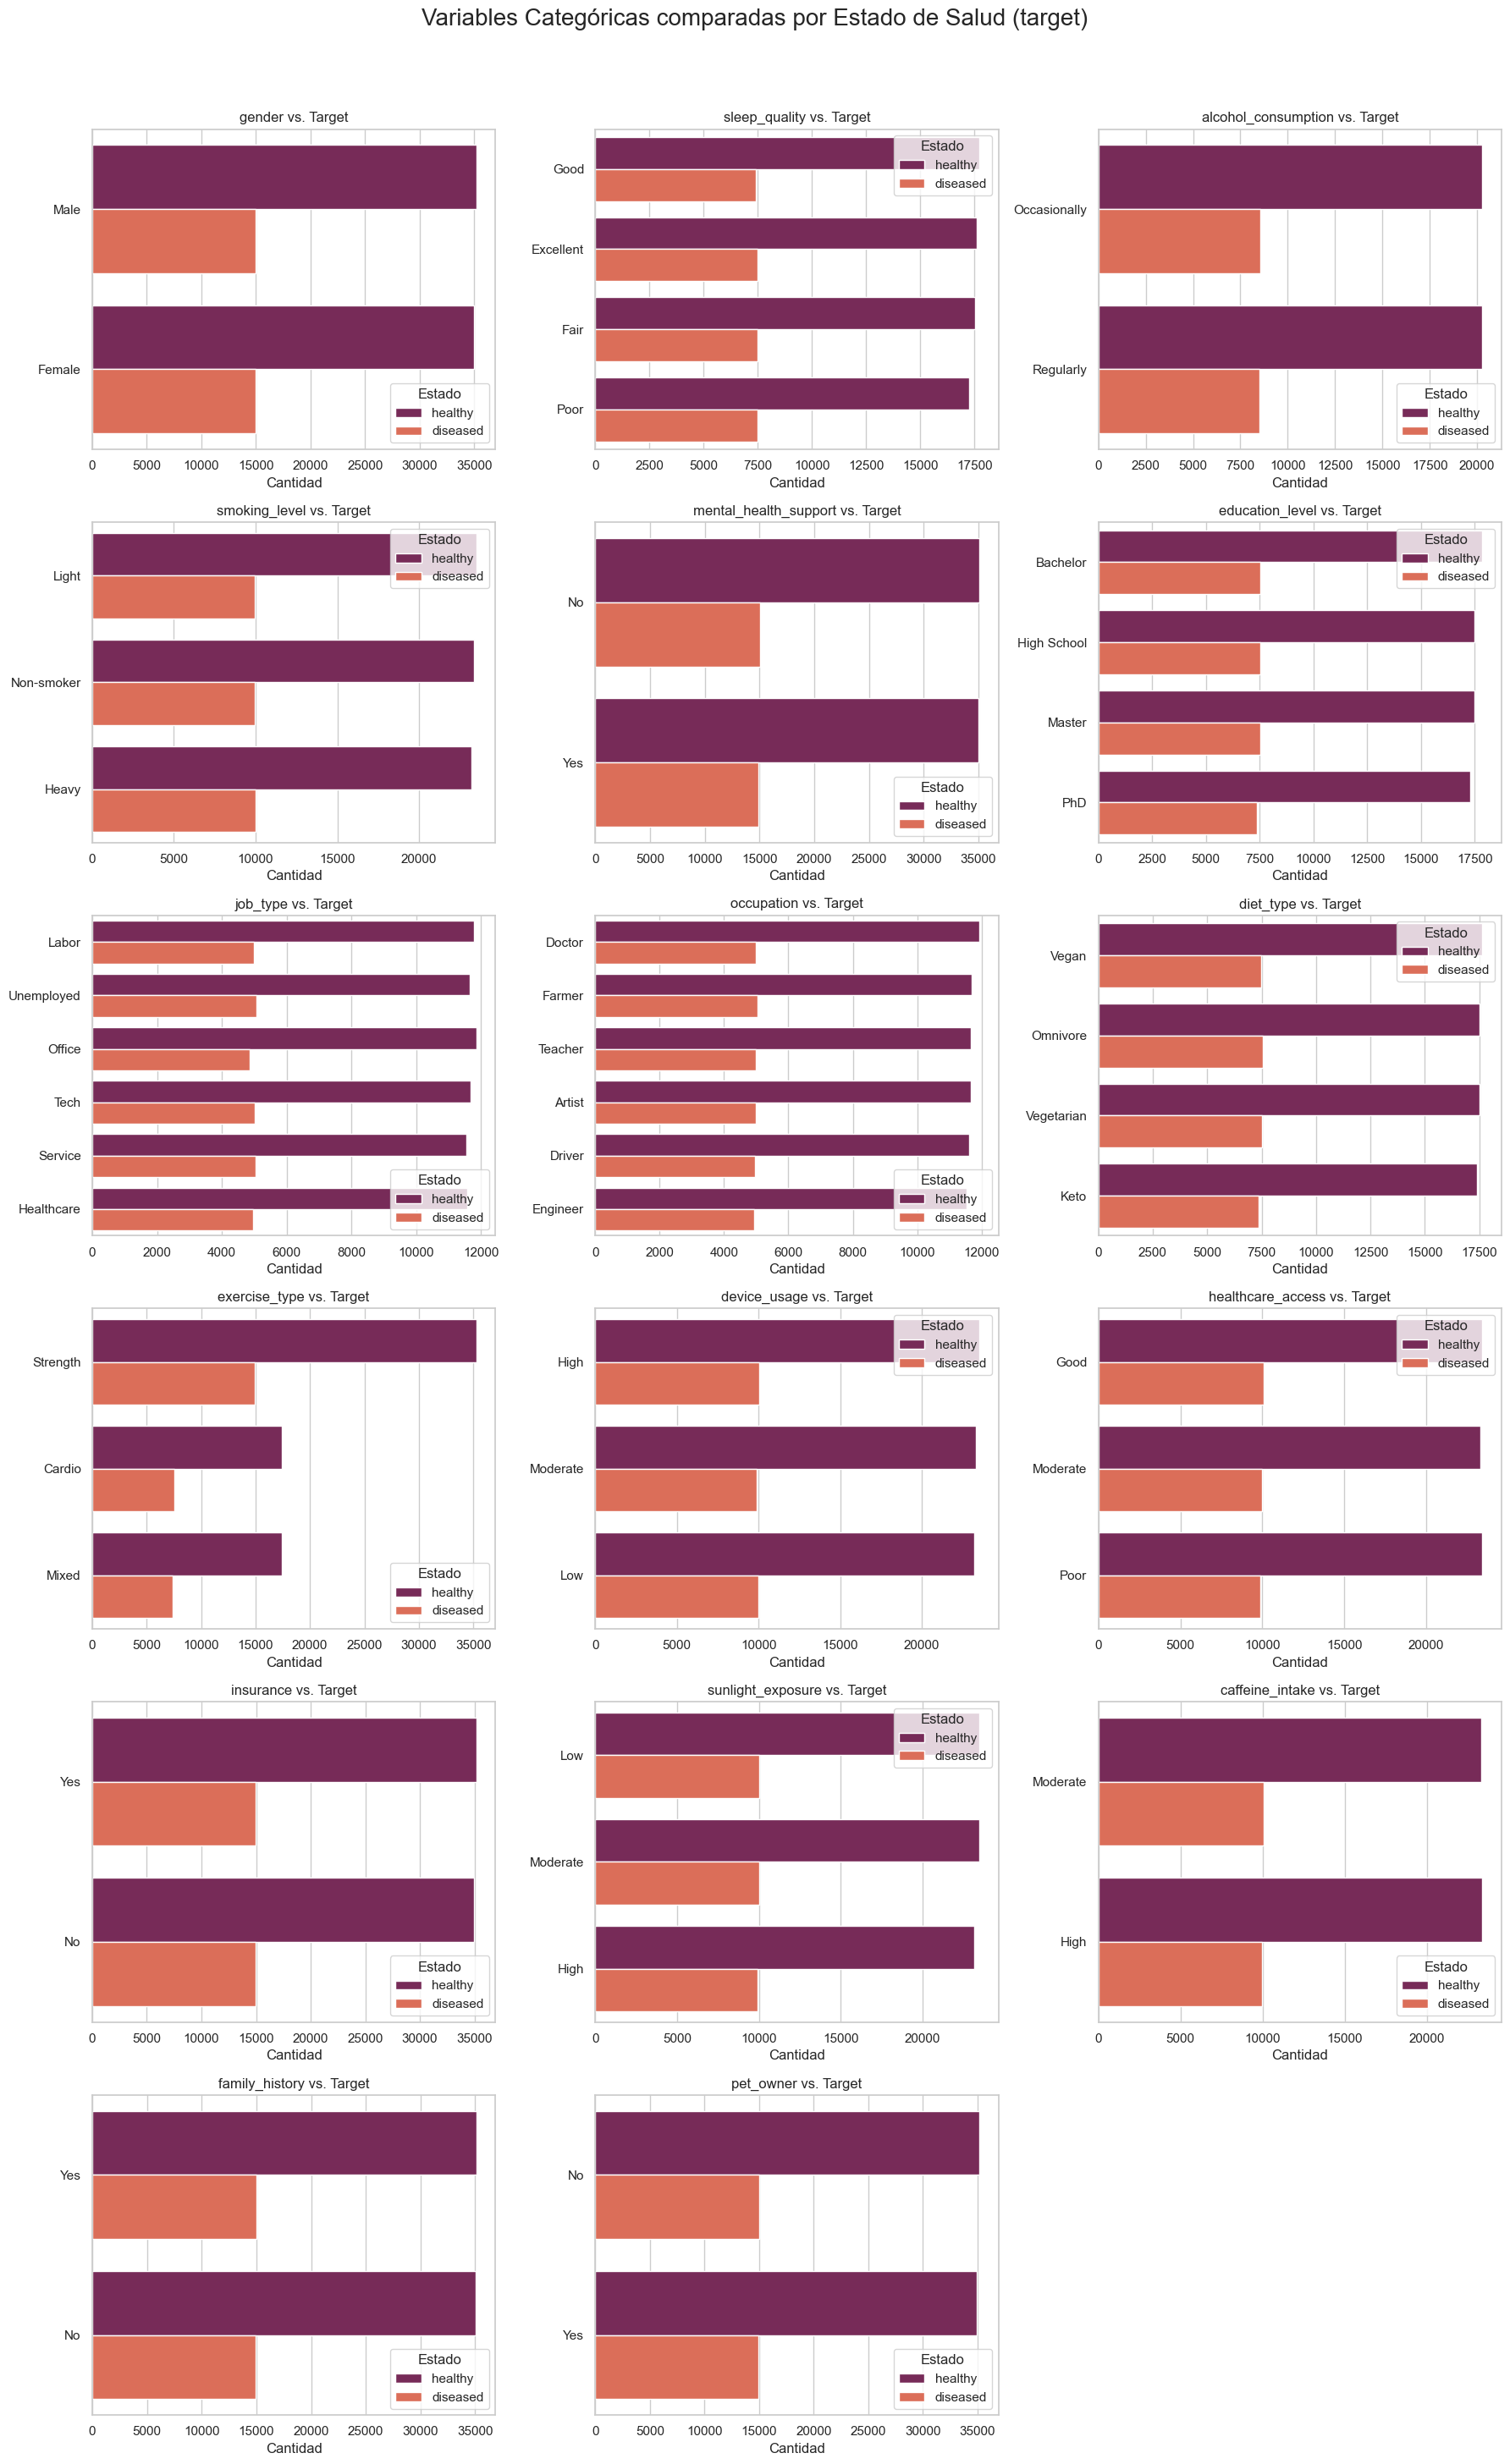

In [16]:
categorical_features = df.select_dtypes(include='object').columns.tolist()
categorical_features.remove('target')

ncols = 3 

n_features = len(categorical_features)
nrows = (n_features + ncols - 1) // ncols

plt.figure(figsize=(18, nrows * 5))
plt.suptitle('Variables Categóricas comparadas por Estado de Salud (target)', size=20, y=1.0)

for i, col in enumerate(categorical_features, 1):

    plt.subplot(nrows, ncols, i)
    sns.countplot(y=col, data=df, hue='target', order=df[col].value_counts().index, palette='rocket')
    plt.title(f'{col} vs. Target')
    plt.xlabel('Cantidad')
    plt.ylabel('')
    plt.legend(title='Estado')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

### 2.5.
En este análisis, comparamos la distribución de las variables categóricas con nuestra variable objetivo para identificar patrones que nos ayuden a predecir la enfermedad.

-   **Asociaciones Fuertes:** Encontramos que hay una clara relación entre el estado de salud y varias variables de estilo de vida y demografía. Notamos que la proporción de individuos "diseased" es notablemente más alta en categorías como:
    -   `sleep_quality`: En la categoría "Poor" (pobre).
    -   `smoking_habit`: En la categoría "Heavy" (fumador empedernido).
    -   `exercise_type`: En la categoría "None" (ninguno).
    -   `family_history`: En la categoría "Yes" (sí).
    -   `healthcare_access`: En la categoría "Poor" (pobre).
    -   `education_level`: En los niveles educativos más bajos (ej. "High School").

-   **Asociaciones Más Débiles:** Por otro lado, variables como `gender` (género) o `pet_owner` no muestran una diferencia tan marcada en la proporción de personas "diseased" entre sus categorías. Esto sugiere que estas variables podrían no ser tan informativas para nuestro modelo predictivo.

### 2.6. Correlación
Realizaremos esto para ver si existe multicolinealidad entre variables.

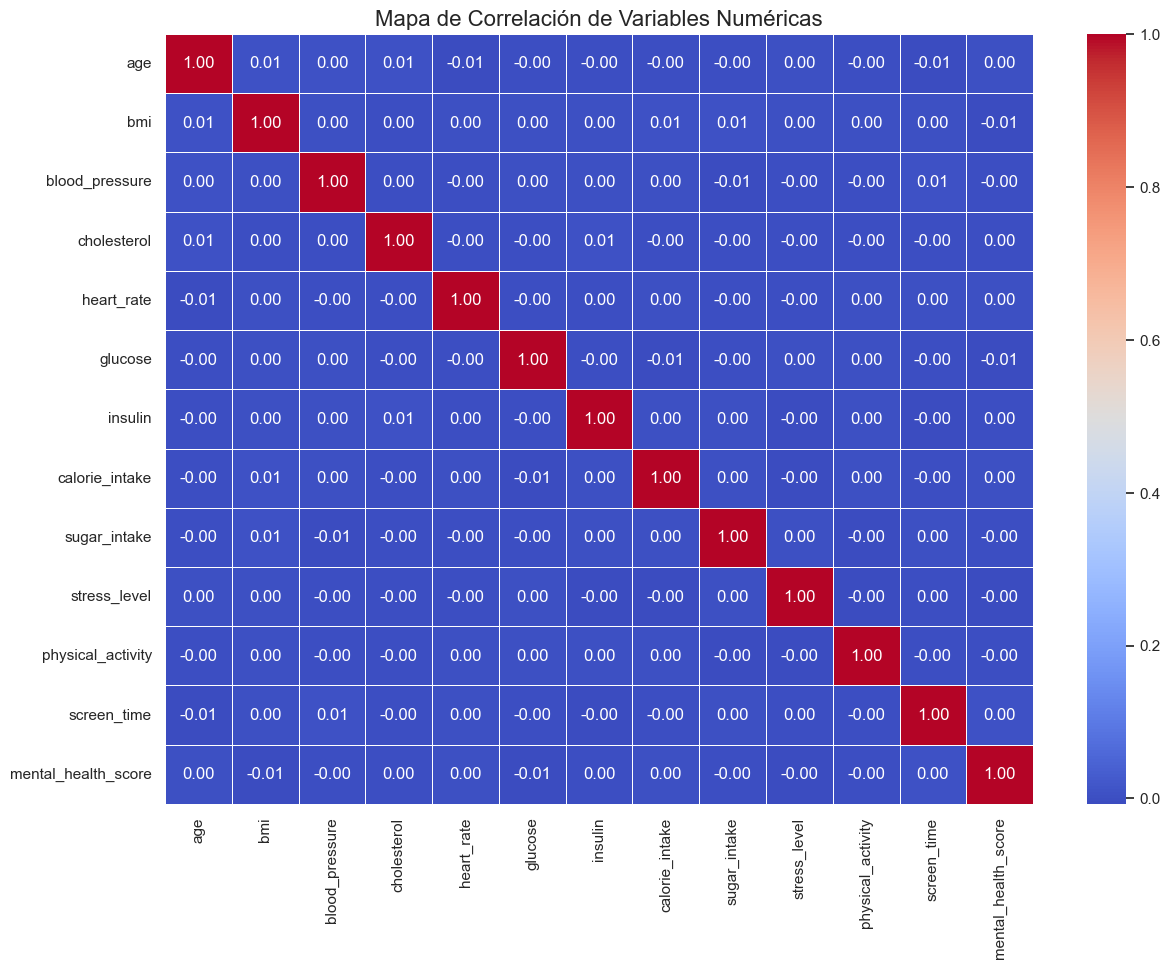

In [17]:
corr_features = ['age', 'bmi', 'blood_pressure', 'cholesterol', 'heart_rate', 'glucose', 'insulin', 'calorie_intake', 'sugar_intake', 'stress_level', 'physical_activity', 'screen_time', 'mental_health_score']
correlation_matrix = df[corr_features].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Correlación de Variables Numéricas', size=16)
plt.show()

Con el mapa de calor de correlación, buscamos entender la relación lineal entre las variables numéricas de nuestro conjunto de datos.

-   **Hallazgo:** El resultado que encontramos es que **no existe una correlación lineal significativa** entre las variables numéricas mostradas.

### 2.7. Conclusión del Análisis Exploratorio de Datos

Nuestro EDA nos ha proporcionado una comprensión esencial de nuestro conjunto de datos y nos ha dado un claro camino a seguir para el modelado.

-   **Preprocesamiento Crucial:** Identificamos la necesidad de limpiar los datos. Encontramos valores nulos en varias columnas, datos inconsistentes (ej. valores negativos en la ingesta de azúcar) y la presencia de outliers que deben ser gestionados cuidadosamente.
-   **Desafío del Target:** Confirmamos que la variable objetivo está desequilibrada (70% sanos vs. 30% enfermos).
-   **Descubrimiento de Predictores:** La mayoría de las variables, tanto numéricas como categóricas, mostraron una fuerte asociación con el estado de salud. Variables como `bmi`, `insulin`, `stress_level`, la `family_history` y el `exercise_type` emergen como los predictores más prometedores para el modelo.
-   **Correlación:** Notamos que las variables numéricas clave no tienen una correlación lineal significativa entre sí, lo cual es una buena señal para evitar la multicolinealidad.